In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmadbarraj","key":"f7e90e159e5aa94ab43549ef0068a85f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d adityajn105/flickr30k


Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr30k
License(s): CC0-1.0
100% 8.16G/8.16G [01:23<00:00, 24.3MB/s]
100% 8.16G/8.16G [01:23<00:00, 105MB/s] 


In [ ]:
!unzip flickr30k.zip -d /content/flickr30k

Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr30k/Images/flickr30k_images/535529555.jpg  
  inflating: /content/flickr30k/Images/flickr30k_images/5356236664.jpg  
  inflating: /content/flickr30k/Images/flickr30k_images/5356318668.jpg  
  inflating: /content/flickr30k/Images/flickr30k_images/535830521.jpg  
  inflating: /content/flickr30k/Images/flickr30k_images/5359437945.jpg  
  inflating: /content/flickr30k/Images/flickr30k_images/5361355399.jpg  
  inflating: /content/flickr30k/Images/flickr30k_images/53614287.jpg  
  inflating: /content/flickr30k/Images/flickr30k_images/536147209.jpg  
  inflating: /content/flickr30k/Images/flickr30k_images/5361551308.jpg  
  inflating: /content/flickr30k/Images/flickr30k_images/536156200.jpg  
  inflating: /content/flickr30k/Images/flickr30k_images/5362687336.jpg  
  inflating: /content/flickr30k/Images/flickr30k_images/5363528971.jpg  
  inflating: /content/flickr30k/Images/flickr30k_images/5363903246.jpg  
  infl

In [ ]:
import os

# List the files in the directory to check if the images are there
images_path = '/content/flickr30k/Images/'
print(os.listdir(images_path)[:10])  # Display the first 10 files


['1167662968.jpg', '1132772170.jpg', '1072439304.jpg', '4841930476.jpg', '3400889730.jpg', '339734472.jpg', '996089206.jpg', '8188882833.jpg', '4545183125.jpg', '1266359954.jpg']


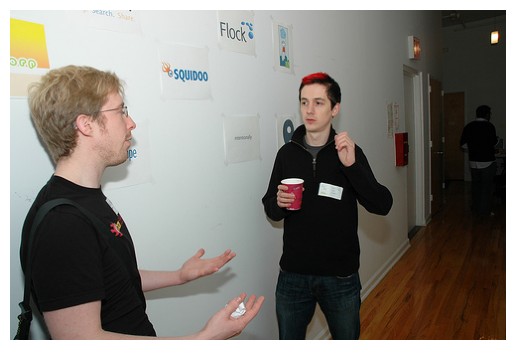

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/flickr30k/Images/86549526.jpg'

try:
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
except FileNotFoundError:
    print("File not found. Please check the path.")


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import pickle
from PIL import Image, UnidentifiedImageError

In [ ]:
# Assuming the images are stored in a folder "Images"
images_path = '/content/flickr30k/Images'


In [ ]:
# Load your captions data and preprocess
captions = "/content/flickr30k/captions.txt"

def load_caption_file(path):

    # dictionary to store captions
    captions_dict = {}

    # iterate through the file
    for caption in open(path):

        # caption has format-> 1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set of stairs in an entry way .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)

        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text

    return captions_dict

# call the function
captions_dict = load_caption_file(captions)





In [ ]:
# clean the captions
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'

In [ ]:
del captions_dict

In [ ]:
print('"' + list(new_captions_dict.keys())[4] + '"' + ' : ' + new_captions_dict[list(new_captions_dict.keys())[4]])

"1000344755" : startseq someone in blue shirt and hat is standing on stair and leaning against window endseq


In [ ]:
len(new_captions_dict)


31784

In [ ]:
caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(images_path) if image.split('.')[0] in image_index ]

In [ ]:
train_validate_images = caption_images_list[:9000]


In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


def extract_features(directory, image_keys):
    # load the model
    model = VGG16()

    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # summarize
    print(model.summary())

    # extract features from each photo
    features = dict()

    for name in image_keys:

        # load an image from file
        filename = directory + '/' + name + '.jpg'

        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))

        # convert the image pixels to a numpy array
        image = img_to_array(image)

        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # prepare the image for the VGG model
        image = preprocess_input(image)

        # get features
        feature = model.predict(image, verbose=0)

        # get image id
        image_id = name.split('.')[0]

        # store feature
        features[image_id] = feature

#         print('>%s' % name)


    return features

In [ ]:
train_validate_features = extract_features(images_path, train_validate_images)


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:

# Save the features to a pickle file
with open('train_validate_features.pkl', 'wb') as f:
    pickle.dump(train_validate_features, f)


In [ ]:

# Load the features from the pickle file
with open('train_validate_features.pkl', 'rb') as f:
    train_validate_features = pickle.load(f)


In [ ]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():

    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):

         train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

9000

In [ ]:
# load libraries
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding,add
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
from keras.utils import to_categorical, plot_model

tokenizer = Tokenizer()

# create word count dictionary on the captions list
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

max_len


74

In [ ]:
def prepare_data(image_keys):
    x1, x2, y = [], [], []

    for image in image_keys:
        if image in train_validate_image_caption:
            caption = train_validate_image_caption[image]
            caption = caption.split()
            seq = tokenizer.texts_to_sequences([caption])[0]

            length = len(seq)

            for i in range(1, length):
                x2_seq, y_seq = seq[:i], seq[i]
                x2_seq = pad_sequences([x2_seq], maxlen=max_len)[0]
                y_seq = to_categorical([y_seq], num_classes=vocab_len)[0]

                if image in train_validate_features:
                    x1.append(train_validate_features[image][0])
                else:
                    print(f"Key {image} not found in train_validate_features.")

                x2.append(x2_seq)
                y.append(y_seq)

        else:
            print(f"Key {image} not found in train_validate_image_caption.")

    return np.array(x1), np.array(x2), np.array(y)

In [ ]:
train_x1, train_x2, train_y = prepare_data(caption_images_list[0:2500] )
validate_x1, validate_x2, validate_y = prepare_data(caption_images_list[2500:3000])

In [ ]:
input_1 = Input(shape=(4096,))
droplayer = Dropout(0.5)(input_1)
denselayer = Dense(256, activation='relu')(droplayer)

# sequence model
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=True)(input_2)
droplayer_ = Dropout(0.5)(embedding)
lstm = LSTM(256, use_cudnn=False)(droplayer_)  # Disable cuDNN here

# decoder model
decoder1 = add([denselayer, lstm])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:

filepath='best_model.keras'

callbacks = [
             ModelCheckpoint(filepath= filepath, save_best_only=True, monitor='val_loss') ,
                 EarlyStopping(monitor='val_loss', patience=3, verbose=1),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)
]



In [ ]:
# fit model
history = model.fit([train_x1, train_x2],
                    train_y,
                    verbose = 1,
                    epochs = 20,
                    #batch_size = 128,
                    callbacks = callbacks,
                    validation_data=([validate_x1, validate_x2], validate_y))

Epoch 1/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 757s 579ms/step - loss: 6.3307 - val_loss: 5.4840
Epoch 2/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 735s 566ms/step - loss: 5.1977 - val_loss: 5.2785
Epoch 3/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 798s 609ms/step - loss: 4.7627 - val_loss: 5.1576
Epoch 4/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 735s 566ms/step - loss: 4.4911 - val_loss: 5.2017
Epoch 5/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 726s 559ms/step - loss: 4.2307 - val_loss: 5.2232
Epoch 6/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 757s 571ms/step - loss: 4.0113 - val_loss: 5.3179
Epoch 7/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 745s 573ms/step - loss: 3.8144 - val_loss: 5.4735
Epoch 8/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 732s 563ms/step - loss: 3.6470 - val_loss: 5.6010
Epoch 9/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 729s 561ms/step - loss: 3.4758 - val_loss: 5.8814
Epoch 10/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 752s 569ms/step - loss: 3.3487 - val_loss: 6.0690
Epoch 11/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 734s 564ms/step - loss: 3.2005 - val

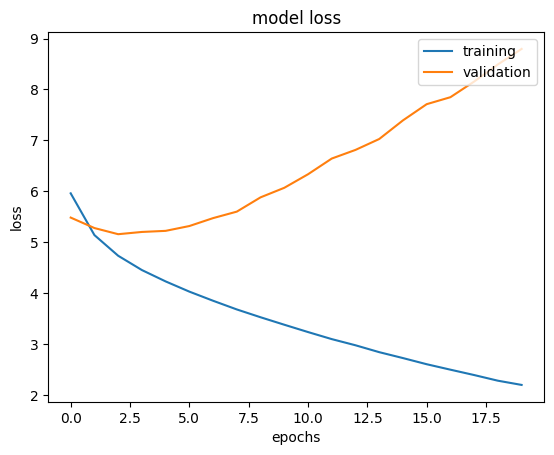

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [ ]:
def extract_feat(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
for count in range(10):

    photo = extract_feat('{}.jpg'.format(images_path+'/'+train_validate_images[count]))

    # generate description
    description = generate_desc(model, tokenizer, photo, max_length=74)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne champagne

Actual caption ->  startseq closeup picture of man with nose ring and brown shirt endseq
*********************************************************************

Predicted caption ->  startseq loungegrill loungegrill loungegrill l

In [ ]:
train_x1, train_x2, train_y = prepare_data(caption_images_list[3000:5900] )
validate_x1, validate_x2, validate_y = prepare_data(caption_images_list[5900:6000])

In [ ]:
#load best model

from keras.models import load_model

# Load the best model
model = load_model('best_model.keras')


In [ ]:
# fit model
history = model.fit([train_x1, train_x2],
                    train_y,
                    verbose = 1,
                    epochs = 20,
                    callbacks = callbacks,
                    validation_data=([validate_x1, validate_x2], validate_y))

Epoch 1/20
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 815s 533ms/step - loss: 6.2409 - val_loss: 5.4605 - learning_rate: 0.0010
Epoch 2/20
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 816s 537ms/step - loss: 5.1553 - val_loss: 5.2146 - learning_rate: 0.0010
Epoch 3/20
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 863s 538ms/step - loss: 4.7499 - val_loss: 5.1168 - learning_rate: 0.0010
Epoch 4/20
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 863s 539ms/step - loss: 4.4540 - val_loss: 5.1021 - learning_rate: 0.0010
Epoch 5/20
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 795s 523ms/step - loss: 4.2138 - val_loss: 5.1653 - learning_rate: 0.0010
Epoch 6/20
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 800s 526ms/step - loss: 4.0175 - val_loss: 5.2590 - learning_rate: 0.0010
Epoch 7/20
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 3.8244
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 801s 526ms/step - loss: 3.8244 - val_loss: 5.4143 - learning_rate: 0.0010
Epoch 7: early stopping


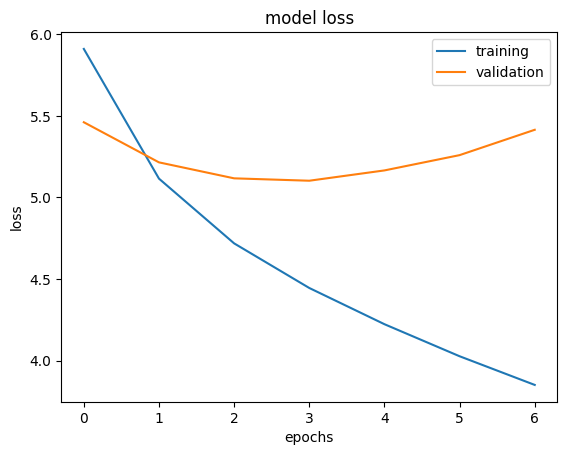

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


In [ ]:
for count in range(10):

    photo = extract_feat('{}.jpg'.format(images_path+'/'+train_validate_images[count]))

    # generate description
    description = generate_desc(model, tokenizer, photo, max_length=61)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq man in blue shirt and blue shirt is sitting on the street while another man in blue shirt and blue shirt endseq

Actual caption ->  startseq closeup picture of man with nose ring and brown shirt endseq
*********************************************************************

Predicted caption ->  startseq man in blue shirt and blue shirt is sitting on bench while another man in blue shirt and blue shirt endseq

Actual caption ->  startseq man is standing with his arms folded looking at something while the person behind him is jumping onto one of the two beds in the room endseq
*********************************************************************

Predicted caption ->  startseq two men are playing on the ground while the other one is wearing blue and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and wh

In [ ]:
train_validate_images = caption_images_list[6000:9000]

In [ ]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():

    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):

         train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

3000

In [ ]:
del train_x1, train_x2, train_y, validate_x1, validate_x2, validate_y

In [ ]:
train_x1, train_x2, train_y = prepare_data(caption_images_list[6000:8900] )
validate_x1, validate_x2, validate_y = prepare_data(caption_images_list[8900:9000])

In [ ]:
# fit model
history = model.fit([train_x1, train_x2],
                    train_y,
                    verbose = 1,
                    epochs = 20,
                    callbacks = callbacks,
                    validation_data=([validate_x1, validate_x2], validate_y))

Epoch 1/20
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 813s 532ms/step - loss: 5.2596 - val_loss: 4.9406 - learning_rate: 2.0000e-04
Epoch 2/20
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 859s 530ms/step - loss: 4.8581 - val_loss: 4.9094 - learning_rate: 2.0000e-04
Epoch 3/20
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 859s 529ms/step - loss: 4.6928 - val_loss: 4.8951 - learning_rate: 2.0000e-04
Epoch 4/20
 181/1527 ━━━━━━━━━━━━━━━━━━━━ 11:54 531ms/step - loss: 4.4669

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


In [ ]:
for count in range(10):

    photo = extract_feat('{}.jpg'.format(images_path+'/'+train_validate_images[count]))

    # generate description
    description = generate_desc(model, tokenizer, photo, max_length=61)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()